## Data figures of CNN performance

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio, rasterio.plot
import shapely as shp
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import pytorch_lightning as pl
import pickle
# import segmentation_models_pytorch as smp
lcv.set_fontsize(10)
path_dict = loadpaths.loadpaths()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


adding scrub
adding wetland
adding transport
Font size is set to 10


In [3]:
model_path = 'LCU_2023-03-24-0222.data'
LCU = lcm.load_model(filename=model_path)
LCU.eval()

with open(LCU.dict_training_details['tile_patch_train_test_split_dict_path'], 'rb') as f:
            dict_tile_patches = pickle.load(f)
            tile_patch_train = dict_tile_patches['train']
            tile_patch_test = dict_tile_patches['test']

path_mapping_dict = LCU.dict_training_details['path_mapping_dict']

dir_test_im_patches = ['/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images_detailed_annotation/',
                            '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_2_tiles/images_detailed_annotation/']
mask_suffix_test_ds = '_lc_2022_detailed_mask.npy'
       
test_ds = lcm.DataSetPatches(im_dir=dir_test_im_patches, mask_dir=None, 
                            mask_suffix=mask_suffix_test_ds, mask_dir_name='masks_detailed_annotation',
                            preprocessing_func=LCU.preprocessing_func, 
                            shuffle_order_patches=True, relabel_masks=True,
                            subsample_patches=False,
                            list_tile_patches_use=tile_patch_test,
                            path_mapping_dict=path_mapping_dict)
test_ds.remove_no_class_patches()
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=10, num_workers=8)

Loaded LCU_2023-03-24-0222
loss_function is cross_entropy
n_max_epochs is 90
LandCoverUNet class using CrossEntropyLoss()
main_categories_F3inDE_noFGH training using randomly split eval patch data. cross_entropy resnet50 90 epochs
Multiple (2) image directories provided. Will concatenate all patches together.
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches ordered randomly
Loaded 308 patches
Loaded label_mapping_dict__main_categories_F3inDE_noFGH__2023-03-17-0957.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 466.85it/s]

Removed 1 patches with no class


In [4]:
df_main = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_FGH-override/landscape_character_2022_FGH-override.shp')
df_detailed = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')
df_tile_outlines = lca.load_pols('../content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
pol_outline = df_tile_outlines[df_tile_outlines['PLAN_NO'] == 'SK1357'].iloc[0]['geometry']
eval_patch_outlines = lca.load_pols('../content/evaluation_sample_50tiles/eval_patch_grid_annotations/eval_patch_grid_annotations.shp')
eval_patch_outlines_2 = lca.load_pols('../content/evaluation_sample_50tiles/eval_2_patch_grid_annotations/eval_2_patch_grid_annotations.shp')
eval_patch_outlines_concat = pd.concat([eval_patch_outlines, eval_patch_outlines_2], axis=0)

df_detailed = lca.test_validity_geometry_column(df_detailed)
df_detailed = df_detailed[df_detailed['Class_low'] != '0']

dict_pols_detailed_rand = lca.get_pols_for_tiles(df_pols=df_detailed, col_name='tile_patch',
                        df_tiles=eval_patch_outlines_concat[np.logical_or(eval_patch_outlines_concat['RAND_ANNOT'] == 1, eval_patch_outlines_concat['SEL_ANNOT'] == 1)], 
                        col_ind_name='Class_low', col_class_name='Class_low')
# dict_tile_patches
dict_pols_detailed_rand = {key[:7] + 'patch' + key[8:].zfill(3): val for key, val in dict_pols_detailed_rand.items()}
dict_area_0 = {}
for tp, df in dict_pols_detailed_rand.items():
    if '0' in df['Class_low'].values:
        dict_area_0[tp] = df[df['Class_low'] == '0']['geometry'].area.sum()
    else:
        dict_area_0[tp] = 0

def map_low_to_high_level(code):
    if code == 'F3a':
        return 'D'
    elif code == 'F3d':
        return 'E'
    else:
        return code[0]
    
for key in dict_pols_detailed_rand.keys():
    dict_pols_detailed_rand[key]['Class_high'] = dict_pols_detailed_rand[key]['Class_low'].apply(map_low_to_high_level)

# n_noclass_pols = np.sum(np.array(list(dict_area_0.values())) > 1)

Geometry Ring Self-intersection[405166.645500001 354069.537799999] for inds [3448]
Attempting to make valid
Done
Geometry Ring Self-intersection[407379.638966848 352904.669116294] for inds [465]
Attempting to make valid
Done
Geometry Ring Self-intersection[407495.557080073 405488.00284208] for inds [1722]
Attempting to make valid
Done
Geometry Ring Self-intersection[407588.8603 352489.939199999] for inds [1316]
Attempting to make valid
Done
Geometry Ring Self-intersection[407597.556900001 352132.544300001] for inds [482]
Attempting to make valid
Done
Geometry Ring Self-intersection[408576.001399294 352149.6823] for inds [4273]
Attempting to make valid
Done
Geometry Ring Self-intersection[414871.025378596 372829.307805445] for inds [2296]
Attempting to make valid
Done
Geometry Ring Self-intersection[415825.015405168 368957.661992135] for inds [1533]
Attempting to make valid
Done
Geometry Ring Self-intersection[421050.500000001 396097.5] for inds [2423]
Attempting to make valid
Done
Geom

100%|██████████| 1028/1028 [00:04<00:00, 223.75it/s]


0 tiles were empty: []


In [33]:
test_ds.df_patches.head()

,patch_name,tile_name,im_filepath,mask_filepath
0,SK2161_patch008,SK2161,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
1,SK1959_patch059,SK1959,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
2,SK0879_patch197,SK0879,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
3,SK1778_patch010,SK1778,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
4,SK1672_patch132,SK1672,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...


In [5]:
dict_colour = {'train': 'blue', 'test': 'red'}

Removing NO CLASS from confusion matrix
adding scrub
adding wetland
adding transport


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>


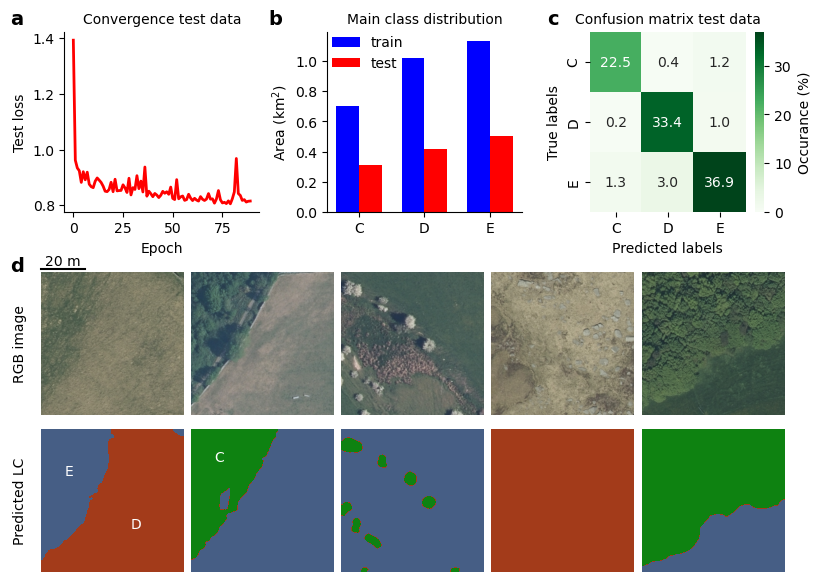

In [47]:
save_fig = True

fig = plt.figure(figsize=(8, 6), constrained_layout=False)
gs_data = fig.add_gridspec(1, 3, wspace=0.35, hspace=0.3, left=0.05, right=0.95, top=0.95, bottom=0.65)
# inds_examples = [10, 26, 39, 40, 77]
names_examples = ['SK0684_patch138', 'SK1871_patch167', 'SK0752_patch049', 
                #   'SK0685_patch219', 
                  'SK0988_patch028', 'SK0682_patch163']
inds_examples = [int(np.where(test_ds.df_patches['patch_name'] == x)[0][0]) for x in names_examples]

n_examples = len(inds_examples)
add_cbar = False
gs_ims = fig.add_gridspec(2, n_examples, wspace=0.05, hspace=0.1, left=0.02, right=0.75 if add_cbar else 0.95, 
                          top=0.55, bottom=0.05)
if add_cbar:
    gs_cbar = fig.add_gridspec(1, 1, left=0.9, right=0.92, top=0.55, bottom=0.05)
    ax_cbar = fig.add_subplot(gs_cbar[0])
else:
    ax_cbar = None

ax_conv = fig.add_subplot(gs_data[ 0])
# lcv.plot_convergence_model(model=LCU, ax=ax_conv, metric='train_loss', colour_line=dict_colour['train'])
lcv.plot_convergence_model(model=LCU, ax=ax_conv, metric='val_loss', colour_line=dict_colour['test'])
ax_conv.set_title('Convergence test data')

ax_distr = fig.add_subplot(gs_data[1])
lcv.plot_distribution_train_test_classes(dict_pols_per_patch=dict_pols_detailed_rand, 
                                         plot_dual_axis=False, colour_dict=dict_colour,
                                         ax=ax_distr, dict_train_test_split=dict_tile_patches,
                                         col_name_class='Class_high', rotation_xticklabels=0)
ax_distr.set_title('Main class distribution')
lcv.despine(ax_distr)
ax_distr.legend(loc='upper left', bbox_to_anchor=(-0.04, 1.05), frameon=False)

ax_conf = fig.add_subplot(gs_data[2])
_ = lcv.plot_confusion_summary(model=LCU, normalise_hm=True, ax_hm=ax_conf,
                               fmt_annot='.1f', print_table=False)
ax_conf.set_title('Confusion matrix test data')

ax_ims = []
ax_lcs = []
for i in range(n_examples):
    ax_ims.append(fig.add_subplot(gs_ims[0, i]))
    ax_lcs.append(fig.add_subplot(gs_ims[1, i]))
assert len(inds_examples) == n_examples
batch, patch_names = lcm.get_any_combination_from_ds(ds=test_ds, list_inds=inds_examples)
predicted_labels = LCU.forward(batch[0])
predicted_labels = lca.change_tensor_to_max_class_prediction(pred=predicted_labels)
## undo preprocessing of image so the true RGB image is shown again:
ims_plot = lca.undo_zscore_single_image(im_ds=batch[0], f_preprocess=test_ds.preprocessing_func)
ims_plot = ims_plot.detach().numpy()
for i in range(n_examples):
    lcv.plot_image_simple(im=ims_plot[i, :, :, :], ax=ax_ims[i])
    lcv.plot_landcover_image(im=predicted_labels[i, :, :], ax=ax_lcs[i], 
                            lc_class_name_list=test_ds.class_name_list, 
                            unique_labels_array=test_ds.unique_labels_arr,
                            plot_colorbar=True if i == (n_examples - 1) and add_cbar else False, 
                            cax=ax_cbar)
    
ax_ims[0].set_ylabel('RGB image')
ax_lcs[0].set_ylabel('Predicted LC')

fig.align_ylabels([ax_conv, ax_ims[0], ax_lcs[0]])
## Plot scale bar:
xlims = ax_ims[0].get_xlim()
ylims = ax_ims[0].get_ylim()
ax_ims[0].plot([0, 512 / 64 * 20], [-10, -10], c='k', clip_on=False)
ax_ims[0].text(s='20 m', x=80, y=-12, ha='center', va='bottom', clip_on=False)
ax_ims[0].set_xlim(xlims)
ax_ims[0].set_ylim(ylims)

## LC labels:
ax_lcs[0].text(s='E', x=100, y=150, ha='center', va='center', zorder=5, c='w')
ax_lcs[0].text(s='D', x=340, y=340, ha='center', va='center', zorder=5, c='w')
ax_lcs[1].text(s='C', x=100, y=100, ha='center', va='center', zorder=5, c='w')

## Panel labels:
ax_conv.text(s='a', x=-0.28, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='b', x=1.05, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='c', x=2.48, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='d', x=-0.28, y=-0.35, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)

if save_fig:
    plt.savefig('../figures/fig_mainclass_stats.pdf', dpi=300, bbox_inches='tight')

In [35]:
inds_examples

[34, 52, 58, 60, 63, 75]

(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
72


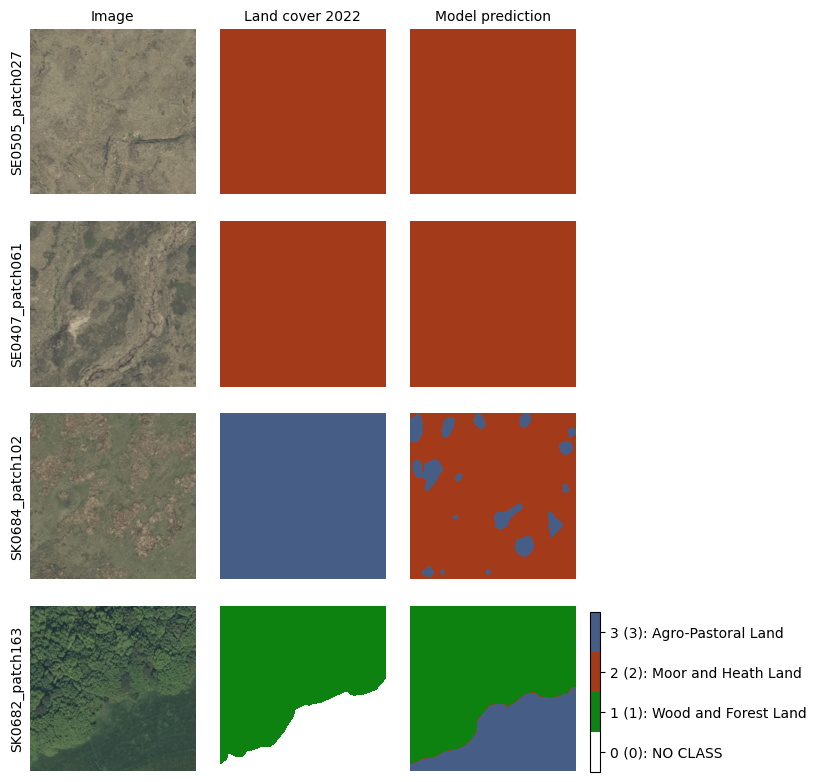

In [31]:
kk += 4
# kk = 32
tmp_batch, names_patches = lcm.get_batch_from_ds(ds=test_ds, 
                                                 batch_size=4, start_ind=kk)
_ = lcm.predict_single_batch_from_testdl_or_batch(model=LCU, batch=tmp_batch,
                                        #  test_dl=test_dl, 
                                         preprocessing_fun=test_ds.preprocessing_func,
                                         lc_class_name_list=test_ds.class_name_list, 
                                         unique_labels_array=test_ds.unique_labels_arr,
                                         names_patches=names_patches)
print(kk)